# Imports and General Settings

In [1]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import model_arch_utility as model_arch
import log_utility as log_util
import data_augmentation_utility as da_util
import load_data_utility as load_data_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


/device:GPU:0


# Data Augmentation

In [2]:
# data augmentation methods in data_augmentation_utility.py

def augment_image(image):
                       
    image = da_util.rotate(image)
    image = da_util.flip(image)
    
    image = da_util.translate(image)
    image = da_util.crop(image)

    return image

# ConvNet

## ConvNet Architecture

In [3]:
num_classes = 3

# ResNet-10 architecture
def convnet_network(x, conv_kernels=[10,7,3], num_channels=8, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('ConvNet', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        counter = 0
        for kernel in conv_kernels:
        
            x = model_arch.conv(x, num_channels, kernel=kernel, stride=2, padding='SAME', scope='conv_' + str(counter))
            x = model_arch.relu(x)
            
            x = model_arch.batch_norm(x, is_training, scope='batch_norm_' + str(counter))
            
            filtered_images.append(tf.identity(x))
            
            counter = counter + 1
            num_channels = num_channels * 2
 
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def convnet_model_fn(features, labels, mode, conv_kernels=[10,7,3], num_channels=8, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = convnet_network(features,
                                                                          conv_kernels=conv_kernels,
                                                                          num_channels=num_channels,
                                                                          n_classes=num_classes,
                                                                          reuse=False,
                                                                          is_training=True)
        
        logits_test, activ_maps_test, _ = convnet_network(features,
                                                          conv_kernels=conv_kernels,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)


        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(activ_maps_train), labels, 20.0, True)
        
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        tf.summary.scalar("loss", loss_op)
        tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

#             conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

#             plot_op_expanded = tf.expand_dims(log_util.plot_conv_weights(conv0_weights), 0)
#             tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    name = "after_conv_" + str(counter)
                    if counter == 0:
                        name = "original_image"
                    
                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(log_util.plot_conv_output(activation_map, name), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 1)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

## Experimentation

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.summary.FileWriterCache.clear()
b_size = 32

learning_rate = 0.001

random_seed = 777

num_steps = 10000

convnet_checkpoint_path_base = "/data/jma/model/synthetic_data/convnet/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.00]

# data_root = "./data/data_relabeled_png/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


train_root = "./data/split/train/"
eval_root = "./data/split/eval/"

train_paths = load_data_util.load_image_paths(train_root)
random.shuffle(train_paths)

eval_paths = load_data_util.load_image_paths(eval_root)

train_input_fn = lambda : load_data_util.load(train_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)

for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            
 
            model_path = convnet_checkpoint_path_base + "model_balanced_train_set_filter8/"
            print(model_path)

            config = tf.estimator.RunConfig(
                log_step_count_steps= 20,
                save_summary_steps= 30,
                save_checkpoints_secs= 30,
                model_dir=model_path,
                tf_random_seed=random_seed,
                session_config=session_config)

            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=False)

            model = tf.estimator.Estimator(model_fn=model_fn, config=config)

            train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
            eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=30)

            tf.estimator.train_and_evaluate(model, train_spec, eval_spec)
        
        

/data/jma/model/synthetic_data/convnet/model_balanced_train_set_filter8/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/synthetic_data/convnet/model_balanced_train_set_filter8/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 30, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff193766278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Sta

INFO:tensorflow:global_step/sec: 5.28151
INFO:tensorflow:loss = 2.1963762e-05, step = 660 (3.787 sec)
INFO:tensorflow:global_step/sec: 5.46846
INFO:tensorflow:loss = 0.00048369827, step = 680 (3.659 sec)
INFO:tensorflow:global_step/sec: 5.3769
INFO:tensorflow:loss = 5.80721e-06, step = 700 (3.717 sec)
INFO:tensorflow:global_step/sec: 5.13407
INFO:tensorflow:loss = 0.0043903342, step = 720 (3.897 sec)
INFO:tensorflow:global_step/sec: 5.418
INFO:tensorflow:loss = 6.332989e-08, step = 740 (3.691 sec)
INFO:tensorflow:global_step/sec: 5.40995
INFO:tensorflow:loss = 0.0015653915, step = 760 (3.697 sec)
INFO:tensorflow:Saving checkpoints for 763 into /data/jma/model/synthetic_data/convnet/model_balanced_train_set_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-03-00:40:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/synthetic_data/convnet/mo

Experimentation

## Evaluation

In [10]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

resnet10_checkpoint_path_base = "/data/jma/model/synthetic_data/convnet/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0]

# data_root = "./data/custom_activation_map_data/"

data_root = "./data/data_relabeled_png_synthetic/"

image_paths = load_data_util.load_image_paths(data_root)
train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed)


eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=1, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet10_checkpoint_path_base + "model1/"
            print(model_path)

            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=False)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

/data/jma/model/relabeled_data/convnet_2layers/model1/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/relabeled_data/convnet_2layers/model1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f064a7b6ef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
in gpu part
IN

# Metrics

## Metric Utility Functions

In [19]:
def path_to_label(paths, data_root):

    data_root = pathlib.Path(data_root)

    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

    # assign index to label
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels

print(eval_paths[:20])


['data/data_relabeled_png_synthetic/1/IM-0019-0026-0001.dcm.png', 'data/data_relabeled_png_synthetic/1/IM-0018-0004-0001.dcm.png', 'data/data_relabeled_png_synthetic/2/IM-0048-0023-0001.dcm.png', 'data/data_relabeled_png_synthetic/1/IM-0064-0004-0001.dcm.png', 'data/data_relabeled_png_synthetic/2/IM-0016-0021-0001.dcm.png', 'data/data_relabeled_png_synthetic/1/IM-0026-0001-0001.dcm.png', 'data/data_relabeled_png_synthetic/1/IM-0049-0026-0001.dcm.png', 'data/data_relabeled_png_synthetic/0/synthetic_71.png', 'data/data_relabeled_png_synthetic/0/synthetic_429.png', 'data/data_relabeled_png_synthetic/0/IM-0046-0026-0001.dcm.png', 'data/data_relabeled_png_synthetic/1/IM-0014-0017-0001.dcm.png', 'data/data_relabeled_png_synthetic/1/IM-0053-0018-0001.dcm.png', 'data/data_relabeled_png_synthetic/1/IM-0066-0016-0001.dcm.png', 'data/data_relabeled_png_synthetic/0/IM-0032-0004-0001.dcm.png', 'data/data_relabeled_png_synthetic/2/IM-0031-0025-0001.dcm copy.png', 'data/data_relabeled_png_synthetic/1

## Confusion Matrices

/data/jma/model/synthetic_data/convnet/model1/
in gpu part


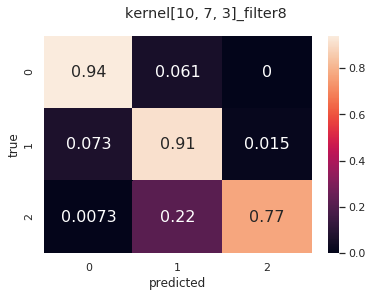

In [20]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

resnet10_checkpoint_path_base = "/data/jma/model/synthetic_data/convnet/"

kernel_sizes = [[10,7,3]]
filter_sizes = [8]
snnl_weights = [0.00]

data_path = "./data/data_relabeled_png_synthetic/"

random_seed = 777

image_paths = load_data_util.load_image_paths(data_path)
train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed)



eval_input_fn = lambda : load_data_util.load(data_path, eval_paths, training=False, augment=False, shuffle=False, batch_size=64)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()

            title = "model1"
            model_path = resnet10_checkpoint_path_base + title +"/"
            print(model_path)
        
        
            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size)
            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            values = model.predict(eval_input_fn)


            original_labels = path_to_label(eval_paths, data_path)
            predicted_labels = list(values)

            cm = tf.confusion_matrix(original_labels, predicted_labels)
            cm = tf.to_float(cm)

            cm = cm.numpy()
            
            row_sums = cm.sum(axis=1)
            cm = cm / row_sums[:, np.newaxis]
            
            df_cm = pd.DataFrame(cm, range(3), range(3))
            #plt.figure(figsize = (10,7))

            sns.set(font_scale=1)#for label size
            plt.suptitle("kernel" + str(kernel_size) + "_filter" + str(filter_size))
            ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
            ax.set(xlabel='predicted', ylabel='true')
            plt.show()
        

## Incorrectly Classified Images (PNG Format)

/data/jma/model/relabeled_data/resnet4/kernel5_filter8_snnl0.0/
in gpu part


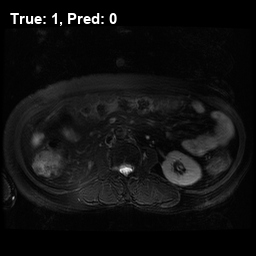

In [ ]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

resnet10_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet4/"

data_path = "./data/data_relabeled_png//"

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=5
filter_size=8
snnl_weight=0.0
#=========

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + "/"
print(model_path)

model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(working_input_fn)

original_labels = path_to_label(working_paths, data_path)
predicted_labels = list(values)

# make a plot?

for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
    